**Install requirements — run only once**

Run the next code cell to install the packages required by this notebook. Use the `%pip` magic so installations target the current Jupyter kernel.

In [93]:
# Install pandas and numpy into the notebook environment (fixing spelling)
# Use %pip so the install targets the current Jupyter environment/kernel
%pip install --upgrade pip
%pip install pandas numpy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Looking at the Initial Dataset

Before we start cleaning, let's load the raw data and take a first look at its structure.

**What we'll check:**
- Preview the first few rows to understand the data format
- Identify the columns available in the dataset
- Look for any obvious data quality issues

This initial exploration helps us understand what we're working with and plan our cleaning strategy.

In [94]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("../data/Reviews.sample.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
2,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
3,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


## Feature Engineering: Creating Sentiment Labels

We'll transform the original 5-star rating system into binary sentiment labels:

**Transformation logic:**
- Scores ≥ 3 → Positive (1)
- Scores < 3 → Negative (0)

We'll also select only the relevant columns (Text and Sentiment) and remove any rows with missing values to ensure data quality.

In [95]:
# Keep relevant columns
df = df[['Score', 'Text']].dropna()
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 3 else 0)
df = df[['Text', 'Sentiment']]
df.head()

,Text,Sentiment
0,Having tried a couple of other brands of glute...,1
1,My cat loves these treats. If ever I can't fin...,1
2,A little less than I expected. It tends to ha...,1
3,"First there was Frosted Mini-Wheats, in origin...",0
4,and I want to congratulate the graphic artist ...,1


## Text Cleaning and Preprocessing

Raw text data contains noise that can hinder model performance. We'll apply standard text cleaning steps:

**Cleaning operations:**
1. Convert to lowercase (standardize text)
2. Remove URLs (not useful for sentiment)
3. Remove punctuation (focus on words)
4. Remove numbers (rarely contribute to sentiment)
5. Remove extra whitespace (normalize formatting)

This creates a `Clean_Text` column with processed reviews ready for analysis.

In [96]:
import re
import string

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+", "", text)  # remove links
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\d+", "", text)  # remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

df['Clean_Text'] = df['Text'].apply(clean_text)
df.head()

,Text,Sentiment,Clean_Text
0,Having tried a couple of other brands of glute...,1,having tried a couple of other brands of glute...
1,My cat loves these treats. If ever I can't fin...,1,my cat loves these treats if ever i cant find ...
2,A little less than I expected. It tends to ha...,1,a little less than i expected it tends to have...
3,"First there was Frosted Mini-Wheats, in origin...",0,first there was frosted miniwheats in original...
4,and I want to congratulate the graphic artist ...,1,and i want to congratulate the graphic artist ...


## Check for Duplicates and Missing Values

Duplicate reviews and missing data can introduce bias and reduce model performance.

**What we're looking for:**
- Null values in any column
- Duplicate reviews (based on cleaned text)

If duplicates are found, we'll remove them to ensure each review is unique in our training data.

In [97]:
df.isnull().sum()
df.duplicated(subset='Clean_Text').sum()
# Remove duplicates
df.drop_duplicates(subset='Clean_Text', inplace=True)


** Inspect Random Samples **

In [98]:
# Pick 5 random positive and negative reviews
print("🟢 Positive Reviews:")
for t in df[df['Sentiment']==1]['Clean_Text'].sample(5, random_state=42):
    print("-", t)
    
print("\n🔴 Negative Reviews:")
for t in df[df['Sentiment']==0]['Clean_Text'].sample(5, random_state=42):
    print("-", t)


🟢 Positive Reviews:
- absolutely delicious and super handy shelfstable asceptic lowfat organic milk saves time and gas money when im out of milk and but need a cup or two an easy way to live a greener life by not driving unnecessarily in the olympia area the cartons can also be recycled check to see if they can in your areabr br these little cartons have earned a permanent spot in my pantry in fact ive signed up for amazons subscriber service where they will automatically send out a box of them at an interval i chose what could be more convenient
- i buy at least a case of this tea every year so i have some all year long and for gift giving most of the people who have received it say that they enjoy it too
- my local pet superstore quit carrying this dogfood which i have been feeding my dog for the last three years i have an year old german sheppard mix petco sold it through amazon though the price was about eight dollars more than what i am used to spending i see that it fluctuates th

** Review length distribution **
- might remove short/really long reviews since they might mess with the results

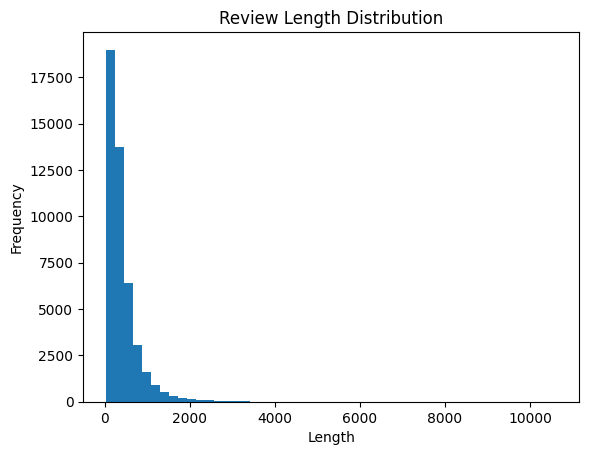

In [99]:
df['length'] = df['Clean_Text'].apply(len)
df['length'].describe()
plt.hist(df['length'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


** removing short/really long review **

In [100]:
min_len = 20
max_len = 2000

before = df.shape[0]
df = df[(df['length'] >= min_len) & (df['length'] <= max_len)]
after = df.shape[0]

print(f"✅ Removed {before - after:,} reviews outside length range ({min_len}–{max_len} chars).")
print(f"Remaining: {after:,} reviews.")


✅ Removed 451 reviews outside length range (20–2000 chars).
Remaining: 45,859 reviews.


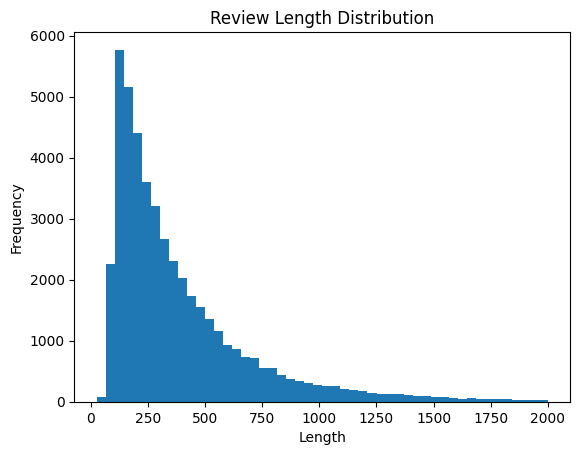

In [101]:
plt.hist(df['length'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

## Data Quality Assessment

Now let's examine the cleaned dataset to understand its characteristics:

**Key metrics to check:**
- Dataset shape (number of rows and columns)
- Data types of each column
- Sentiment class distribution (how balanced are positive vs negative reviews?)

Understanding these properties helps us identify potential issues like class imbalance that may affect model training.

In [102]:
print("Shape:", df.shape)
df.info()
df['Sentiment'].value_counts(normalize=True)

Shape: (45859, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 45859 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        45859 non-null  object
 1   Sentiment   45859 non-null  int64 
 2   Clean_Text  45859 non-null  object
 3   length      45859 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


Sentiment
1    0.85861
0    0.14139
Name: proportion, dtype: float64

## Visualize Sentiment Distribution

Let's create a bar chart to see how balanced our dataset is between positive and negative sentiments.

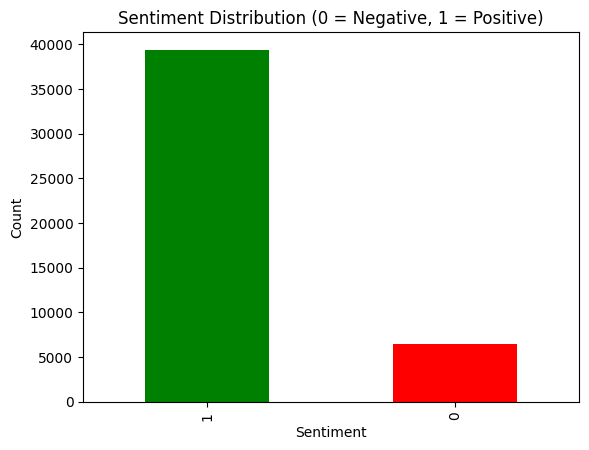

In [103]:
import matplotlib.pyplot as plt

df['Sentiment'].value_counts().plot(kind='bar', color=['green','red'])
plt.title("Sentiment Distribution (0 = Negative, 1 = Positive)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

## Save Cleaned Dataset

Now that we've completed all cleaning and preprocessing steps, let's save the cleaned dataset for use in model training.

The cleaned dataset will include:
- `Clean_Text`: Preprocessed review text
- `Sentiment`: Binary label (0 = Negative, 1 = Positive)
- `Text`: Original text (for reference)
- `length`: Character count of cleaned text

We see that the data is a skewed for positive we'll need to balance it somehow.
we'll keep it like this for now till we see the first result of the training

In [104]:
df.to_csv("../data/clean_reviews.csv", index=False)
print("✅ Clean dataset saved as data/clean_reviews.csv")

✅ Clean dataset saved as data/clean_reviews.csv
